(data_container)=
# Using Data Containers

:::{post} Dec 16, 2021
:tags: posterior predictive, shared data 
:category: beginner
:author: Juan Martin Loyola, Kavya Jaiswal, Oriol Abril, Jesse Grabowski
:::

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from numpy.random import default_rng

plt.rcParams["figure.constrained_layout.use"] = True

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.0


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = sum(map(ord, "Data Containers in PyMC"))
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Introduction

After building the statistical model of your dreams, you're going to need to feed it some data. Data is typically introduced to a PyMC model in one of two ways. Some data is used as an exogenous input, called `X` in linear regression models, where `mu = X @ beta`. Other data are "observed" examples of the enodgenous outputs of your model, called `y` in regression models, and is used as inputs to the likelihood function implied by your model. These data, either exogenous or endogenous, can be included in your model as wide variety of datatypes, including numpy `ndarrays`, pandas `Series` and `DataFrame`, and even pytensor `TensorVariables`. Although you can pass these "raw" datatypes to your PyMC model, the best way is to use one of two {class}`pymc.Data` containers. 

These containers make it extremely easy to work with data in a PyMC model. They offer a range of benefits, including:

1. Visualization of data as a component of your probabilistic graph
2. Access to labeled dimensions for readability and accessibility
3. Support for swapping out data for out-of-sample prediction, interpolation/extrapolation, forcasting, etc.

This notebook will illustrate each of these benefits in turn, and show you the best way to integrate data into your PyMC modeling workflow. 

## Types of Data Containers

 PyMC offers two data containers, depending on your needs: {class}`pymc.ConstantData` and {class}`MutableData`. Both will help you visualize how data fits into your model, store the data in an `InfereceData` for reproducibility, and give access to labeled dimenions. As the names suggest, however, only `MutableData` allows you to change your data. When `X` is `MutableData`, this enables out-of-sample inference tasks. When `y` is `MutableData`, it allows you to reuse the same model on multiple datasets to perform parameter recovery studies or sensitivity analysis.  These abilities do, however, come with a small performance cost.
 
 In past versions of PyMC, the only data container was `pm.Data`. This container is still available for backwards compatability, but the current best practice is to use either `pm.MutableData` or `pm.ConstantData`, depending on your needs. 

## Constant Data

The `pm.ConstantData` is a way to add fixed data to a model. It provides a speed boost in exchange for the ability to change the data. If you don't plan on doing out-of-sample prediction, `pm.ConstantData` is for you. 

In the example shows some of the differences between using a data container, in this case `pm.ConstantData`, and "raw" data. This first model shows how raw data, in this case a numpy array, can be directly provided to a PyMC model.

In [3]:
true_mu = 3
true_std = 5
x = rng.normal(loc=true_mu, scale=true_std, size=100)
with pm.Model() as no_data_model:
    mu = pm.Normal("mu")
    sigma = pm.Exponential("sigma", 1)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=x)

Looking at the resulting computational graph, the `obs` node is shaded gray to indicate that it has observed data. But the data itself is not shown on the graph.  

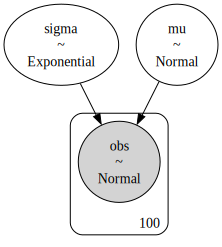

In [4]:
pm.model_to_graphviz(no_data_model)

In this next model, we create a `pm.ConstantData` container to hold the observations, and pass this container to the `observed`:

In [5]:
with pm.Model() as no_data_model:
    data = pm.ConstantData("data", x)
    mu = pm.Normal("mu")
    sigma = pm.Exponential("sigma", 1)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=data)

Because we used a `pm.ConstantData` container, the data now appears on our probabilistic graph. It is downstream from `obs` (since the `obs` variable "causes" the data), shaded in gray (because it is observed), and has a special rounded square shape to emphasize that it is data.    

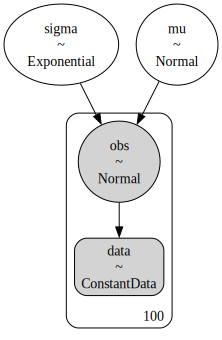

In [6]:
pm.model_to_graphviz(no_data_model)

### Named dimensions with data containers

Both `pm.MutableData` and `pm.ConstantData` allow users to keep track of dimensions (like dates or cities) and coordinates (such as the actual date times or city names) of multi-dimensional data. Both allow you to specify the dimension names and coordinates of random variables, instead of specifying the shapes of those random variables as numbers. Notice that in the previous probabilistic graphs, the nodes `obs` and `data` were in a box with the number 100. A natural question for anyone is, "100 what?". Dimensions and coordinates help organize models, variables, and data by answering exactly this question.

In the next example, we generate an artifical dataset of temperatures in 3 cities over 2 months. We will then use named dimensions and coordinates to improve the readability of the model code and the quality of the visualizations.

In [7]:
df_data = pd.DataFrame(columns=["date"]).set_index("date")
dates = pd.date_range(start="2020-05-01", end="2020-07-01")

for city, mu in {"Berlin": 15, "San Marino": 18, "Paris": 16}.items():
    df_data[city] = rng.normal(loc=mu, size=len(dates))

df_data.index = dates
df_data.index.name = "date"
df_data.head()

,Berlin,San Marino,Paris
date,,,
2020-05-01,15.750302,16.635097,16.889402
2020-05-02,14.496045,16.610578,17.260310
2020-05-03,13.611092,17.649258,17.174489
2020-05-04,13.335488,16.832592,15.321219
2020-05-05,14.694291,18.914369,17.125378


As noted above, `ConstantData` gives you the ability to give named labels to the dimensions of your data. This is done by passing a dictionary of `dimension: coordinate` key-value paris to the `coords` argument of {class}`pymc.Model` when you create your model.

For more explanation about dimensions, coordinates and their big benefits, we encourage you to take a look at the {ref}`ArviZ documentation <arviz:xarray_for_arviz>`.

This is a lot of explanation -- let's see how it's done! We will use a hierarchical model: it assumes a mean temperature for the European continent and models each city relative to the continent mean:

In [8]:
# The data has two dimensions: date and city
# The "coordinates" are the unique values that these dimensions can take
coords = {"date": df_data.index, "city": df_data.columns}

In [9]:
with pm.Model(coords=coords) as model:
    data = pm.ConstantData("observed_temp", df_data, dims=("date", "city"))

    europe_mean = pm.Normal("europe_mean_temp", mu=15.0, sigma=3.0)
    city_offset = pm.Normal("city_offset", mu=0.0, sigma=3.0, dims="city")
    city_temperature = pm.Deterministic(
        "expected_city_temp", europe_mean + city_offset, dims="city"
    )

    sigma = pm.Exponential("sigma", 1)
    pm.Normal("temperature", mu=city_temperature, sigma=sigma, observed=data, dims=("date", "city"))

    idata = pm.sample(
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [europe_mean_temp, city_offset, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Once again, we can look at the probabilistic graph implied by our model. As before, similar node (or groups of nodes) are grouped inside plates. The plates are labeled with the dimensions of each node. Before, we had the label 100 and asked, "100 what?". Now we see that in our model, there are 3 cities and 62 dates. Each of the 3 cities has it's own offset, which, together with a group average, determines the estimated temperature. Finally, we see that our data is actually a 2d matrix. Adding labeled dimensions has greatly improved the presentation of our probabilistic model. 

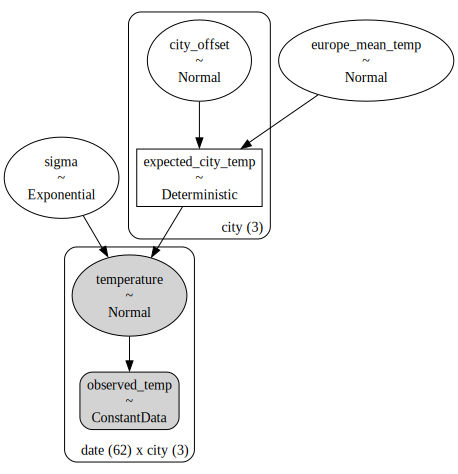

In [10]:
pm.model_to_graphviz(model)

And we see that the model did remember the coords we gave it:

In [11]:
for k, v in model.coords.items():
    print(f"{k}: {v[:20]}")

date: (Timestamp('2020-05-01 00:00:00'), Timestamp('2020-05-02 00:00:00'), Timestamp('2020-05-03 00:00:00'), Timestamp('2020-05-04 00:00:00'), Timestamp('2020-05-05 00:00:00'), Timestamp('2020-05-06 00:00:00'), Timestamp('2020-05-07 00:00:00'), Timestamp('2020-05-08 00:00:00'), Timestamp('2020-05-09 00:00:00'), Timestamp('2020-05-10 00:00:00'), Timestamp('2020-05-11 00:00:00'), Timestamp('2020-05-12 00:00:00'), Timestamp('2020-05-13 00:00:00'), Timestamp('2020-05-14 00:00:00'), Timestamp('2020-05-15 00:00:00'), Timestamp('2020-05-16 00:00:00'), Timestamp('2020-05-17 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-19 00:00:00'), Timestamp('2020-05-20 00:00:00'))
city: ('Berlin', 'San Marino', 'Paris')


Coordinates are automatically stored into the {class}`arviz.InferenceData` object:

In [12]:
idata.posterior.coords

Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * city     (city) <U10 'Berlin' 'San Marino' 'Paris'

Coordinates are also used by `arviz` when making plots. Here we pass `legend=True` to `az.plot_trace` to automatically label the three cities in our trace plot.

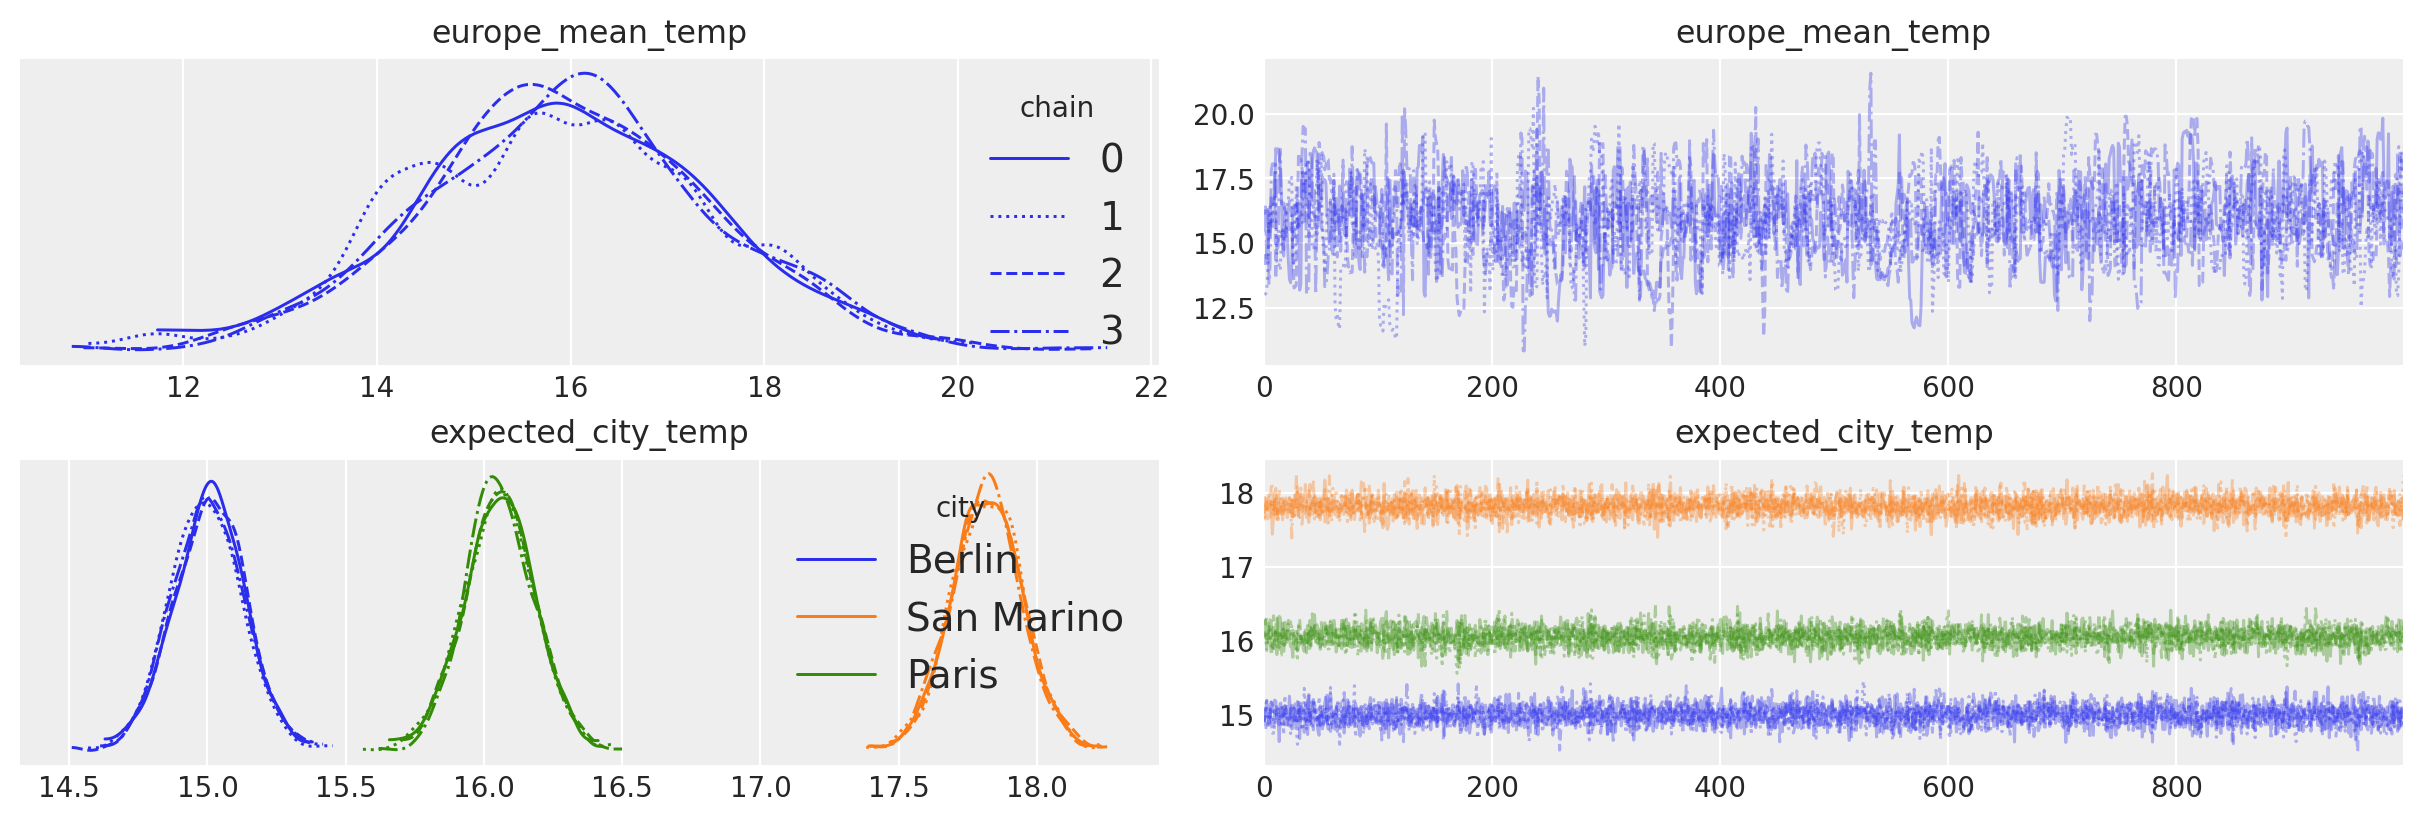

In [13]:
axes = az.plot_trace(idata, var_names=["europe_mean_temp", "expected_city_temp"], legend=True);

When we use `pm.ConstantData`, the data are internally represented as a pytensor {class}`pytensor.tensor.TensorConstant`.

In [14]:
type(data)

pytensor.tensor.var.TensorConstant

The values of all `pytensor` tensors, which includes both `ConstantData` and `MutableData`, can be checked using the `eval` method. All `PyMC` variables, including `Data` containers, can be accessed by indexing the model object with a variable name. Since this line:

```python
    data = pm.ConstantData("observed_temp", df_data, dims=("date", "city"))
```

Gave the name "observed_temp" to the data, we can access it as follows: 

In [15]:
model["observed_temp"].eval()[:15]

array([[15.75030169, 16.63509681, 16.88940204],
       [14.49604455, 16.61057778, 17.26031044],
       [13.61109241, 17.64925828, 17.17448877],
       [13.3354883 , 16.8325924 , 15.32121907],
       [14.69429122, 18.91436857, 17.12537777],
       [17.30852209, 18.58756337, 15.54965076],
       [13.58959185, 18.34373197, 16.22619251],
       [12.83145741, 18.09349753, 15.55868058],
       [15.26931165, 18.34942481, 13.84102677],
       [14.89038138, 16.94523695, 15.20712124],
       [14.76735135, 19.79037682, 14.78983447],
       [16.22878   , 17.11026126, 15.20305382],
       [14.92279894, 18.22903688, 14.63541736],
       [14.28656227, 17.4868317 , 16.57916854],
       [14.92345158, 18.48712659, 15.2053795 ]])

## MutableData

In many cases, you will want the ability to switch out data between model runs. This arises when you want to fit a model to multiple datasets, or if you are interested in out-of-sample prediction. For these cases, `pm.MutableData` is the correct tool.

### Using MutableData container variables to fit the same model to several datasets

We can use `MutableData` container variables in PyMC to fit the same model to several datasets without the need to recreate the model each time (which can be time consuming if the number of datasets is large). Note, however, that the model will still be recompilied each time. 

In the next example, we will generate 10 models with a single parameter, `mu`. Each model will have a dataset with a different number of observations, from 10 to 100. We will use this setup to explore the effect of data quantity on parameter recovery. 

In [16]:
# We generate 10 datasets
n_models = 10
obs_multiplier = 10

true_mu = [rng.random() for _ in range(n_models)]
observed_data = [mu + rng.normal(size=(i + 1) * obs_multiplier) for i, mu in enumerate(true_mu)]

with pm.Model() as model:
    data = pm.MutableData("data", observed_data[0])
    mu = pm.Normal("mu", 0, 10)
    pm.Normal("y", mu=mu, sigma=1, observed=data)

Once again, the name of our data is `data`, so we can look at it's type. Unlike `pm.ConstantData`, we now see class is now {class}`pytensor.compile.sharedvalue.SharedVariable`.

In [17]:
type(model["data"])

pytensor.tensor.sharedvar.TensorSharedVariable

This difference in type is just an implemention detail. If you are interested in learning more about the ins and outs of pytensor, you can check out this tutorial on how it is used in PyMC: {ref}pymc_pytensor. For our purposes here, it suffices to note that both are symbolic tensors, and the values of all symbolic tensors can be quickly checked using the `eval` method: 

In [18]:
model["data"].eval()

array([-0.62902517,  1.94957464,  1.6050212 ,  0.42282054,  0.0354635 ,
       -0.30779132, -0.6750614 , -1.00017046, -1.54928802, -0.97667572])

While `eval` can be used to check the values, {func}`pymc.set_data` is used to change them. Let's use the `MutableData` together with `pymc.set_data` to repeatedly fit the same model to multiple datasets. Note that it doesn't matter that each dataset has a different size!

In [19]:
# Generate one trace for each dataset
traces = []
for data_vals in observed_data:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        traces.append(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


Arviz's {func}`arviz.plot_forest` allows you to pass a list of `idata`  objects with the same variables names. In this way, we can quickly visualize the different estimates from the 10 different datasets. We also use `matplotlib` to scatter the true parameter values on top of the `plot_forest`. We can see that as we go from 10 observations in model 1 to 100 observations in model 10, the estimates become increasing centered on the true value of mu, and the uncertainty around the estimate goes down.

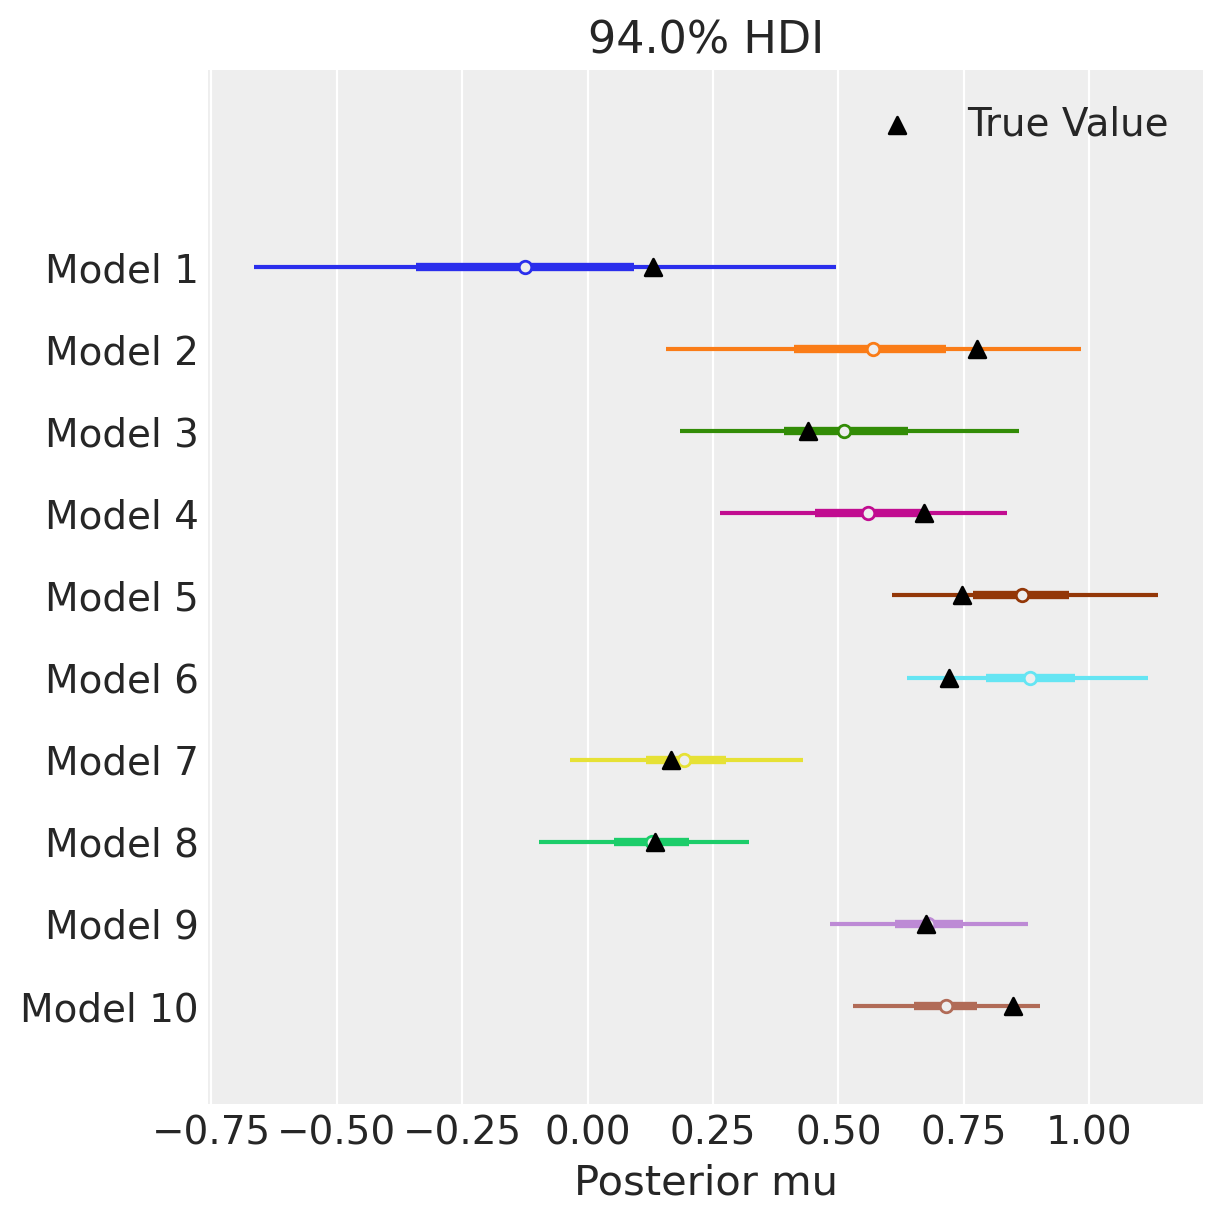

In [20]:
model_idx = np.arange(n_models, dtype="int")
axes = az.plot_forest(traces, var_names=["mu"], combined=True, figsize=(6, 6), legend=False)

ax = axes[0]
y_vals = np.stack([ax.get_lines()[i].get_ydata() for i in np.arange(n_models)]).ravel()
ax.scatter(true_mu, y_vals[::-1], marker="^", color="k", zorder=100, label="True Value")
ax.set(yticklabels=[f"Model {i+1}" for i in model_idx[::-1]], xlabel="Posterior mu")
ax.legend()
plt.show()

### Using MutableData container variables to predict on new data

A common task in machine learning is to predict values for unseen data, and the `MutableData` container variable is exactly what we need to do this. 

One small detail to pay attention to in this case is that the shapes of the input data (`x`) and output data (`obs`) must be the same. When we make out-of-sample predictions, we typically change only the input data, the shape of which may not be the same as the training observations. Naively changing only one will result in a shape error. There are two solutions:

1. Use a `pm.MutableData` for the `x` data and the `y` data, and use `pm.set_data` to change `y` to something of the same shape as the test inputs. 
2. Tell PyMC that the shape of the `obs` should always be the shape of the input data.

In the next model, we use option 2. This way, we don't need to pass dummy data to `y` every time we want to change `x`.

In [21]:
n_obs = 100
true_beta = 1.5
true_alpha = 0.25

x = rng.normal(size=n_obs)
true_p = 1 / (1 + np.exp(-(true_alpha + true_beta * x)))
y = rng.binomial(n=1, p=true_p)

As you can see, we can even mix-and-match `pm.ConstantData` and `pm.MutableData`, depending on which data we plan to change. In this example, we don't plan to do any post-estimation tasks with `y`, so we can put it in a `ConstantData` container.

In [22]:
with pm.Model() as logistic_model:
    x_data = pm.MutableData("x", x)
    y_data = pm.ConstantData("y", y)

    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta")

    p = pm.Deterministic("p", pm.math.sigmoid(alpha + beta * x_data))

    # Here is were we link the shapes of the inputs (x_data) and the observed varaiable
    # It will be the shape we tell it, rather than the (constant!) shape of y_data
    obs = pm.Bernoulli("obs", p=p, observed=y_data, shape=x_data.shape[0])

    # fit the model
    idata = pm.sample()
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


A common post-estimation diagonstic is to look at a posterior predictive plot, using {func}`arviz.plot_ppc`. This shows the distribution of data sampled from your model along side the observed data. If they look similar, we have some evidence that the model isn't so bad.

In this case, however, it can be difficult to interpret a posterior predictive plot. Since we're doing a logistic regression, observed values can only be zero or one. The posterior predictive graph thus has this tetris-block shape. What are we to make of it? 

<Axes: xlabel='obs / obs'>

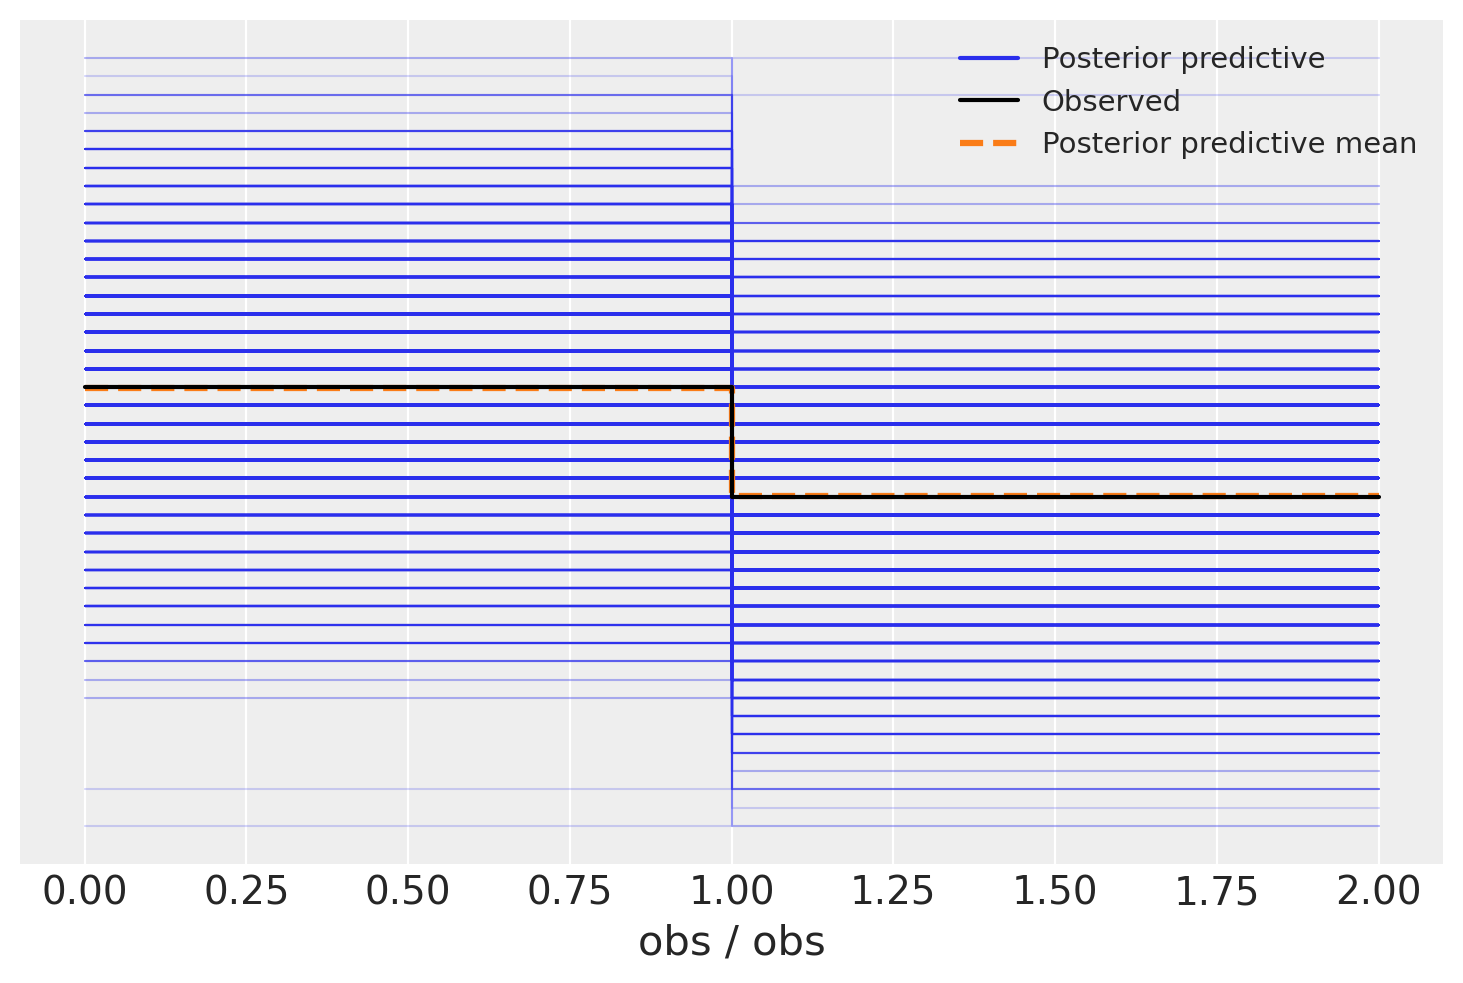

In [23]:
az.plot_ppc(idata)

Another graph we could make to see how our model is doing is to look at how the latent variable `p` evolves over the space of covariates. We expect some relationship between the covariate and the data, and our model encodes that relationship in the variable `p`. In this model, the only covariate is `x`. If the relationship between `x` and `y` is positive, we expect low `p` and lots of observed zeros where `x` is small, and high `p` and lots of observed ones where it is large.  

That's nice and all, but for plotting `x` is all jumbled up. We could just sort the values, but another way is to pass sorted grid of `x` values into our model. This corresponds to making a preditiction for `p` at every point on the grid, which will give us a nice plottable result.

In the next code block, we swap out the (randomly shuffled) values of `x` for an evenly-spaced grid of values that spans the range of observed `x`.

In [24]:
grid_size = 250
x_grid = np.linspace(x.min(), x.max(), grid_size)
with logistic_model:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    # We do not need to set data for the outputs because we told the model to always link the shape of the output to the shape
    # of the input.
    pm.set_data({"x": x_grid})
    post_idata = pm.sample_posterior_predictive(idata, var_names=["p", "obs"])

Sampling: [obs]


Using the new `post_idata`, which holds the out-of-sample "predictions" for `p`, we make the plot of `x_grid` against `p`. We also plot the observed data. We can see that the model expects low probability (`p`) where `x` is small, and that the probability changes very gradually with `x`. 

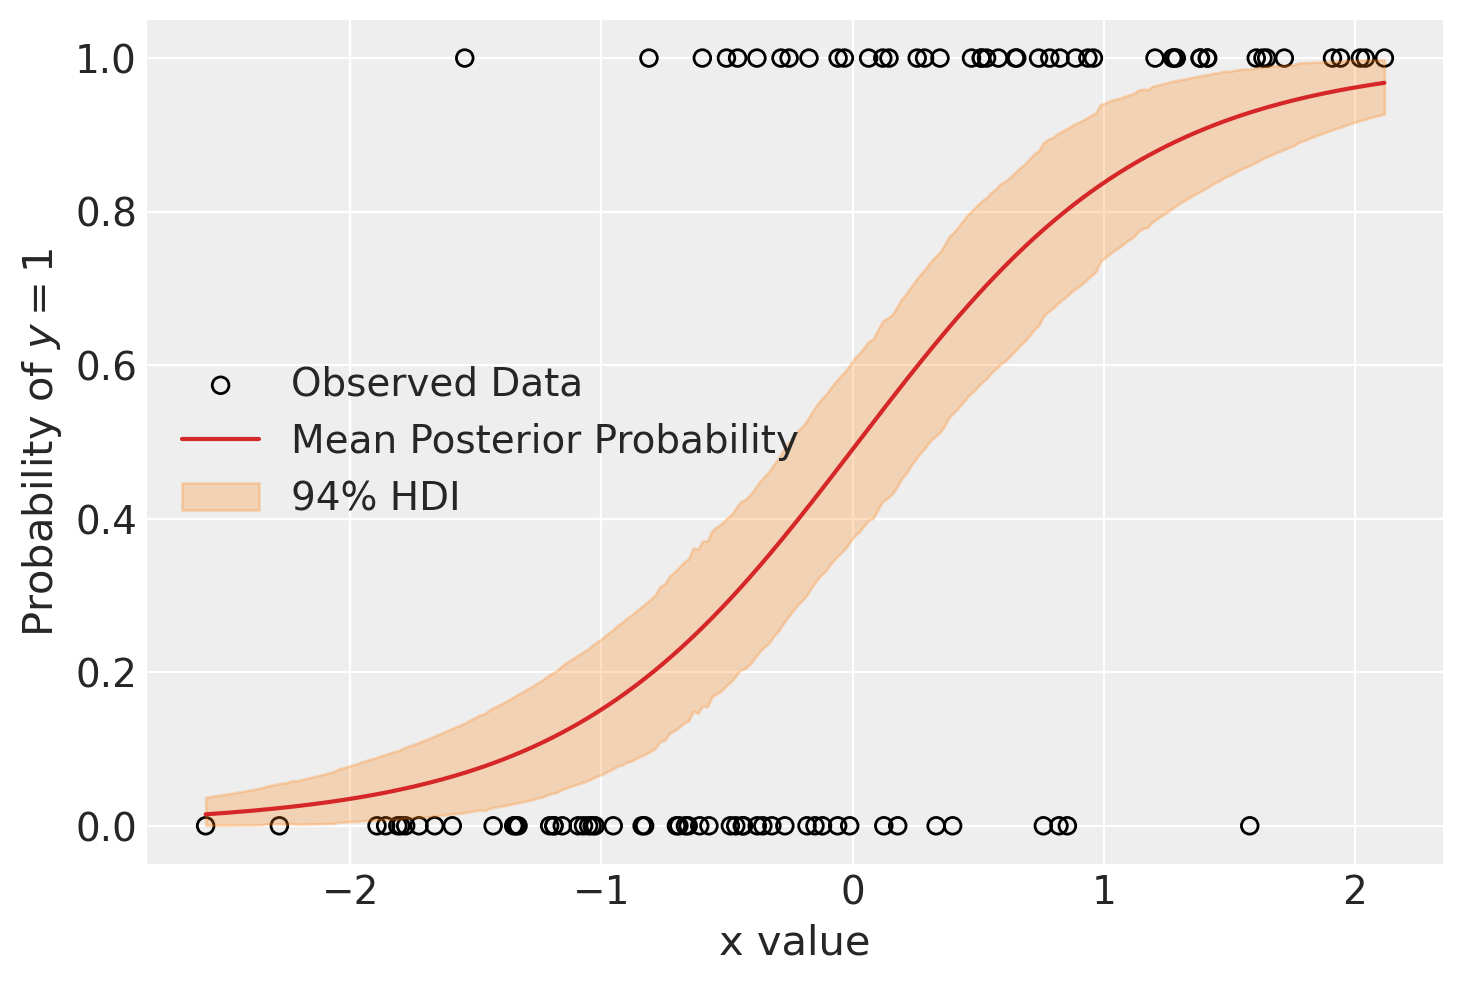

In [25]:
fig, ax = plt.subplots()
hdi = az.hdi(post_idata.posterior_predictive.p).p

ax.scatter(x, y, facecolor="none", edgecolor="k", label="Observed Data")
p_mean = post_idata.posterior_predictive.p.mean(dim=["chain", "draw"])
ax.plot(x_grid, p_mean, color="tab:red", label="Mean Posterior Probability")
ax.fill_between(x_grid, *hdi.values.T, color="tab:orange", alpha=0.25, label="94% HDI")
ax.legend()
ax.set(ylabel="Probability of $y=1$", xlabel="x value")
plt.show()

The same concept applied to a more complex model can be seen in the notebook {ref}`bayesian_neural_network_advi`.

## Applied example: height of toddlers as a function of age

This example is taken from Osvaldo Martin's book: [Bayesian Analysis with Python: Introduction to statistical modeling and probabilistic programming using PyMC and ArviZ, 2nd Edition](https://www.amazon.com/Bayesian-Analysis-Python-Introduction-probabilistic-ebook/dp/B07HHBCR9G) {cite:p}`martin2018bayesian`.

The World Health Organization and other health institutions around the world collect data
for newborns and toddlers and design [growth charts standards](http://www.who.int/childgrowth/en/). These charts are an essential component of the paediatric toolkit and also as a measure of the general well-being of
populations in order to formulate health policies, and plan interventions and
monitor their effectiveness.

An example of such data is the lengths (heights) of newborn / toddler girls as a function of age (in months):

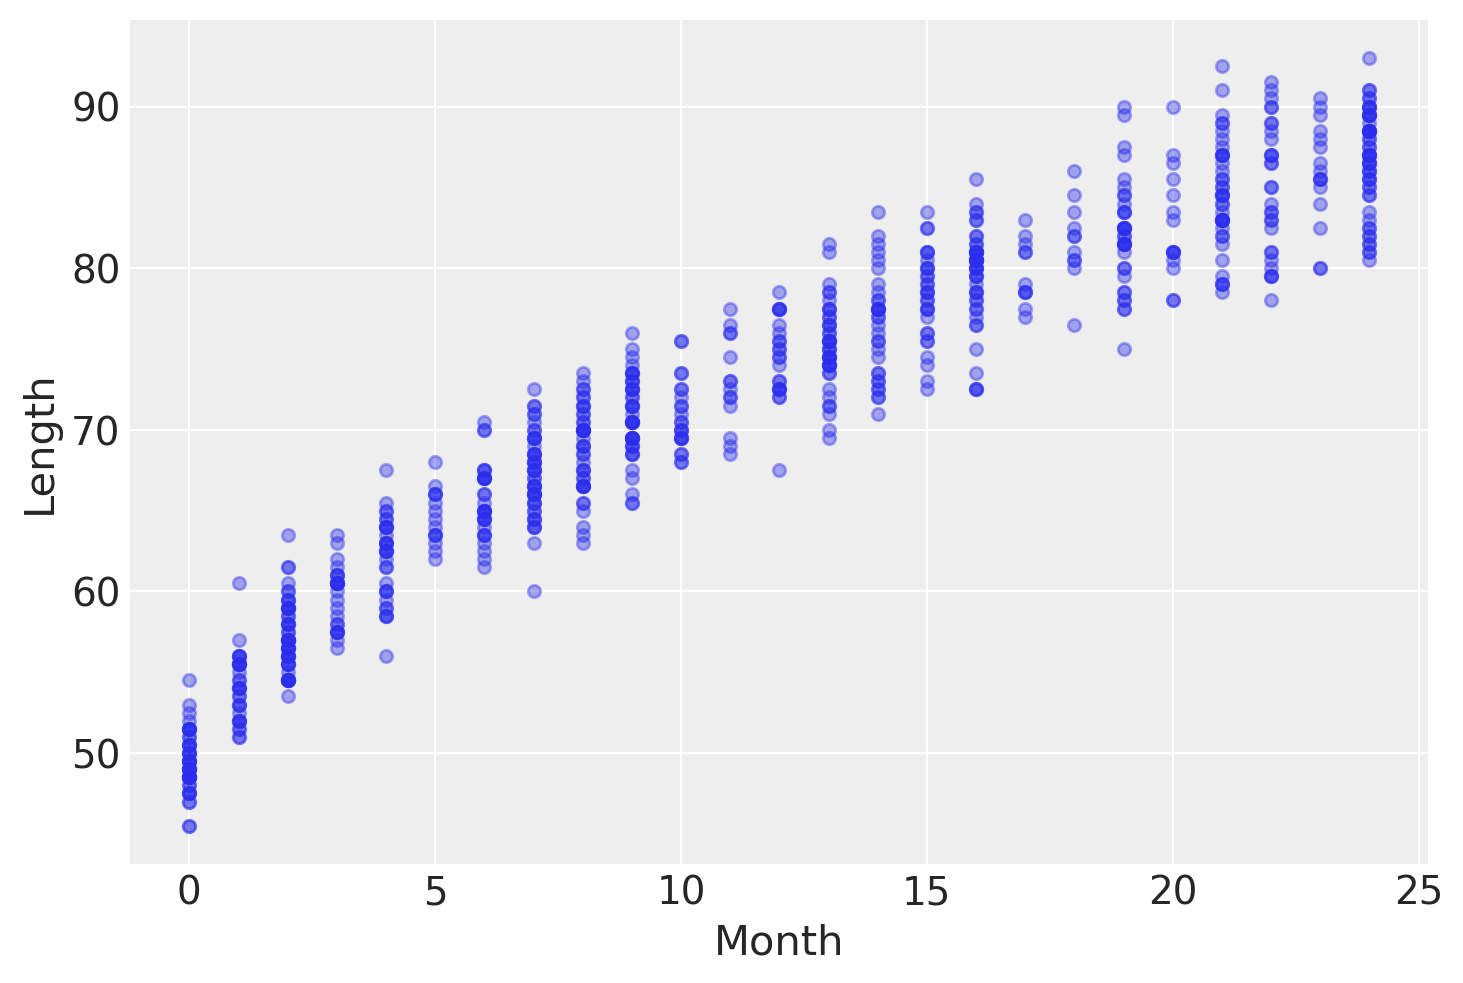

In [26]:
try:
    data = pd.read_csv("../data/babies.csv")
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("babies.csv"))
data.plot.scatter("Month", "Length", alpha=0.4);

To model this data, we will introduce one new feature: mutable `coords`. When we know we have a coord that is going to need to change in the future, like the index of data we will change between training and test sets, we can set the model `coords` via the `coords_mutable` keyword argument.

You are also allowed to specify both `coords` and `coords_mutable` in the same model. In this next model, we will always have the same parameters, so the `parameters` coord is specified as constant via `coords`, while the `obs_idx` will change when we go to do out-of-sample prediction.  

Finally, we plan to use to use this model to do some out-of-sample prediction. Thus, we will opt for `pm.MutableData` as the data container. Note that we are allowed to label the dimensions of a `pm.MutableData` just like `pm.ConstantData`.

In [27]:
with pm.Model(
    coords_mutable={"obs_idx": np.arange(len(data))}, coords={"parameter": ["intercept", "slope"]}
) as model_babies:
    mean_params = pm.Normal("mean_params", sigma=10, dims=["parameter"])
    sigma_params = pm.Normal("sigma_params", sigma=10, dims=["parameter"])
    month = pm.MutableData("month", data.Month.values.astype(float), dims=["obs_idx"])

    mu = pm.Deterministic("mu", mean_params[0] + mean_params[1] * month**0.5, dims=["obs_idx"])
    sigma = pm.Deterministic("sigma", sigma_params[0] + sigma_params[1] * month, dims=["obs_idx"])

    length = pm.Normal("length", mu=mu, sigma=sigma, observed=data.Length, dims=["obs_idx"])

    idata_babies = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_params, sigma_params]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


The following figure shows the result of our model. The expected length, $\mu$, is represented with a blue curve, and two semi-transparent orange bands represent the 60% and 94% highest posterior density intervals of posterior predictive length measurements:

In [28]:
with model_babies:
    pm.sample_posterior_predictive(idata_babies, extend_inferencedata=True)

Sampling: [length]


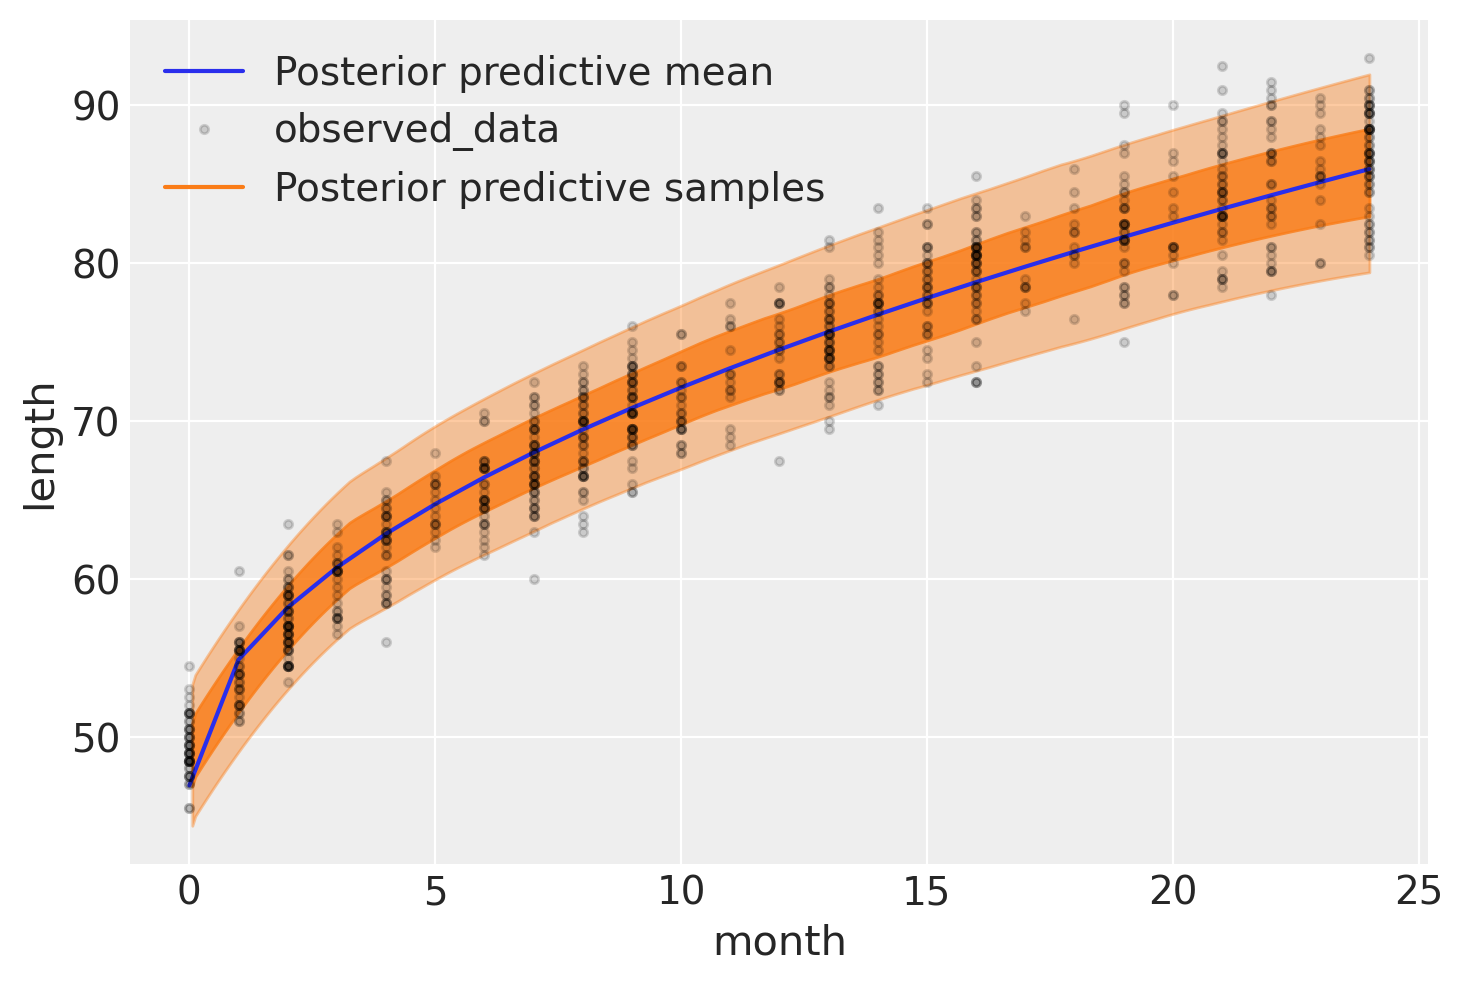

In [29]:
ax = az.plot_hdi(
    data.Month,
    idata_babies.posterior_predictive["length"],
    hdi_prob=0.6,
    fill_kwargs={"alpha": 0.8},
)
ax.plot(
    data.Month,
    idata_babies.posterior["mu"].mean(("chain", "draw")),
    label="Posterior predictive mean",
)
ax = az.plot_lm(
    idata=idata_babies,
    y="length",
    x="month",
    kind_pp="hdi",
    y_kwargs={"color": "k", "ms": 6, "alpha": 0.15},
    y_hat_fill_kwargs=dict(fill_kwargs={"alpha": 0.4}),
    axes=ax,
)

At the moment of writing Osvaldo's daughter is two weeks ($\approx 0.5$ months) old, and thus he wonders how her length compares to the growth chart we have just created. One way to answer this question is to ask the model for the distribution of the variable length for babies of 0.5 months. Using PyMC we can ask this questions with the function `sample_posterior_predictive` , as this will return samples of _Length_ conditioned on the obseved data and the estimated distribution of parameters, that is including uncertainties. 

The only problem is that by default this function will return predictions for _Length_ for the observed values of _Month_, and $0.5$ months (the value Osvaldo cares about) has not been observed, -- all measures are reported for integer months. The easier way to get predictions for non-observed values of _Month_ is to pass new values to the `Data` container we defined above in our model. To do that, we need to use `pm.set_data` and then we just have to sample from the posterior predictve distribution. We will also have to set `coords` for these new observations, which we are allowed to do in the `pm.set_data` function because we have set the `obs_idx` coord as mutable. 

Note that the actual value we pass for `obs_idx` is totally irrevelant *in this case*, so we give it a value of 0. What is important is that we update it to have the same length as the ages we want to do out-of-sample prediction for, and that each age has a unique index identifier.

In [30]:
ages_to_check = [0.5]
with model_babies:
    pm.set_data({"month": ages_to_check}, coords={"obs_idx": [0]})

    # Setting predictions=True will add a new "predictions" group to our idata. This lets us store the posterior,
    # posterior_predictive, and predictions all in the same object.
    idata_babies = pm.sample_posterior_predictive(
        idata_babies, extend_inferencedata=True, predictions=True
    )

Sampling: [length]


Now we can plot the expected distribution of lengths for 2-week old babies and compute additional quantities -- for example the percentile of a child given her length. Here, let's imagine that the child we're interested in has a length of 51.5:

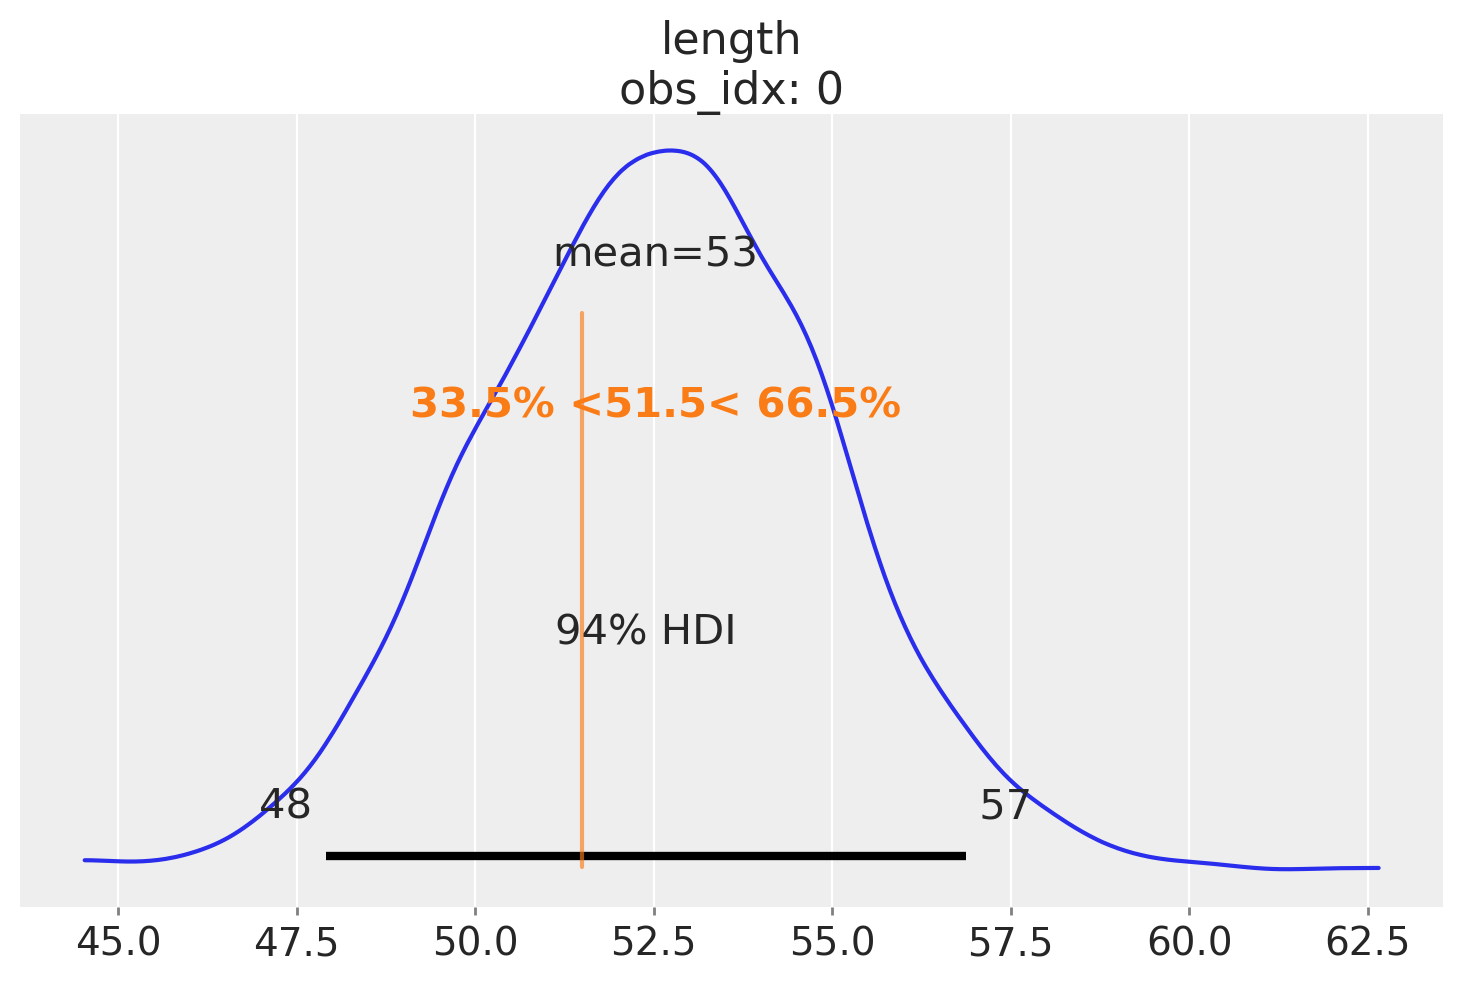

In [31]:
ref_length = 51.5

az.plot_posterior(
    idata_babies,
    group="predictions",
    ref_val={"length": [{"ref_val": ref_length}]},
    labeller=az.labels.DimCoordLabeller(),
);

## Authors
* Authored by [Juan Martin Loyola](https://github.com/jmloyola) in March, 2019 ([pymc#3389](https://github.com/pymc-devs/pymc/pull/3389))
* Updated by [Kavya Jaiswal](https://github.com/KavyaJaiswal) and [Oriol Abril](https://github.com/OriolAbril) in December, 2021 ([pymc-examples#151](https://github.com/pymc-devs/pymc-examples/pull/151))
* Updated by [Jesse Grabowski](https://github.com/jessegrabowski) in July 2023 ([pymc-examples#559](https://github.com/pymc-devs/pymc-examples/pull/559))

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Sat Jul 15 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

pytensor: 2.12.3
xarray  : 2023.6.0

arviz     : 0.15.1
matplotlib: 3.7.2
pandas    : 2.0.3
pymc      : 5.6.0
numpy     : 1.24.4

Watermark: 2.4.3



:::{include} ../page_footer.md
:::